<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install transformers --upgrade
#!pip install transformers -q
#!pip install wandb -q
!pip3 install --upgrade wandb
!pip3 install dill -q

In [3]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle
import dill
import tarfile
import json, gzip
import math
from typing import Optional, Union
import os

import wandb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#!cp '/root/optimizers.py' '/root/Projects/' # SSH
#!cp '/home/jupyter/optimizers.py' '/home/jupyter/Projects/' # for GCP
#!cp '/content/drive/My Drive/Colab Notebooks/optimizers.py' .


from optimizers import AdaFactor

In [5]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Thu Jul 23 12:50:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [ ]:
##!wandb login fac9119080ca108ca15c420ede645a5e6e79a07c

### First Log in 

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'Final_Project.ipynb'

#### Getting dataset

You can find the dataset [here](http://lil.nlp.cornell.edu/newsroom/download/index.html)

**Loading data**

In [ ]:
# fname = '/content/drive/My Drive/Colab Notebooks/newsroom-release.tar'

# tar = tarfile.open(fname, "r:")
# tar.extractall()
# tar.close()

In [ ]:
#!mv '/content/data/' '/content/drive/My Drive/Colab Notebooks'

In [ ]:
#!cp -r '/content/release/' '/content/drive/My Drive/Colab Notebooks/data'

In [4]:
#path = '/home/jupyter/' # GCp
path = '/root/release/' # SSH
#path = "/content/drive/My Drive/Colab Notebooks/data/release/" # Colab

def read_data(path, name):
  data = []
  with gzip.open(path + name + ".jsonl.gz") as f: #+".jsonl.gz" with GCP
      for ln in f:
          obj = json.loads(ln)
          data.append(obj)
  return data

trainset = read_data(path, 'train') 
devset = read_data(path, 'dev')
#testset = read_data(path, 'test')

In [5]:
def get_data(data):
  data_dict = {'text': [], 'summary': []}
  for article in data:
    data_dict['text'].append(article['text'])
    data_dict['summary'].append(article['summary'])
  return pd.DataFrame(data_dict)

train_data = get_data(trainset)
valid_data = get_data(devset)
# test_data = get_data(testset)

In [9]:
train_data.head()

,text,summary
0,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...
3,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [10]:
print(f'The size of training dataset:{train_data.shape} | validation dataset: {valid_data.shape}')

The size of training dataset:(995041, 2) | validation dataset: (108837, 2)


In [6]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [12]:
train_data.isna().sum(), valid_data.isna().sum()

(text       0
 summary    0
 dtype: int64, text       0
 summary    0
 dtype: int64)

##### Preprocessing

In [7]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    date_pattern = r'(0?[1-9]/|1[0-2]/)(0?[1-9]/|[1-2][0-9]/|3[0-1]/)[0-9]{4}'
    line = line.split("\n")
    clean_line = []
    for l in line:
        if re.match(date_pattern, l) is not None:
            pass
        else:
            clean_line.append(l)
    line = "\n".join(clean_line)

    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r"www\S+", " ",line)
    line = line.replace('—', ' ')
    line = line.replace('-', ' ')
    line = line.replace('&', 'and')
    line = line.replace('[...]', '')
    line = line.replace('...', '.')
    line = line.replace('…', ' ')
    line = re.sub(re.compile('<.*?>'), '', line)
    line = re.sub(re.compile('@\S+'), r'', line)
    line = re.sub(r'#\S+ ', r'', line)
    line = line.replace("â", "'") 
    line = line.replace('--', ' ')
    line = re.sub(r'[^\sa-zA-Z0-9.,!?]',' ',line)
    line = line.strip()
    line = line.replace("\xa0", "")
    line = line.replace("click to share on twitter", "")

    line = re.sub(r'[ \t]{2,}',' ', line)
    return line

  def transform(self, X):
    #X = X[self.column].replace(self.contraction)
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [8]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction

    
  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['text', 'summary']
      data_dict = {}

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        data_dict[title] = res

      ss = pd.DataFrame(data_dict)
      
      return ss

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['summary'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      min_len, dataframe = self.get_max_tokens(dataframe)
    else:
      min_len = self.max_length

    min_length = min_len['min_article_tokens']
    idx_list = []
    for idx, paragraph in tqdm(enumerate(dataframe['text'])):
        pragraph = len(paragraph.split())
        if pragraph < min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)

    max_len, final_data = self.get_max_tokens(final_data)

    print('Done!')
    
    return final_data, max_len

In [9]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 100,
          'min_summary_tokens': 0}

In [10]:
textproc = Processor(train_data, contraction, maxlen)
train_processed, doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


995041it [00:31, 31844.18it/s]


Done!


In [12]:
train_processed.to_pickle("./train_processed.pkl")

In [6]:
train_processed = pd.read_pickle("./train_processed.pkl")

In [13]:
textproc = Processor(valid_data, contraction, maxlen)
valid_processed, valid_doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


108837it [00:03, 32442.50it/s]


Done!


In [14]:
valid_processed.to_pickle("./valid_processed.pkl")

In [7]:
valid_processed = pd.read_pickle("./valid_processed.pkl")

In [9]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951381 entries, 0 to 951380
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         951381 non-null  object
 1   summary      951381 non-null  object
 2   article_len  951381 non-null  int64 
 3   summary_len  951381 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 29.0+ MB


Only one article droped that was having zeros length. However we still have some article with no summaries. Therefore we can get rid off them.

In [28]:
doc_lengths

In [8]:
indices = np.where(train_processed['summary_len'] < 10)
train_processed_data = train_processed.drop(indices[0])
train_processed_data = train_processed_data.reset_index(drop=True)
#train_processed.iloc[indices[0]]

In [30]:
#train_data.iloc[954753]['summary'] # '<ul>\n\t<li><b>£', 'Ø¨Ø§ Ø§Û\x8cÙ\x86 Ø§Ø\xadØ³Ø§Ø³ Ø¯Ø±Ù\x85Ø§Ù\x86Ø¯Ú¯Û\x8cØ\x8c Ø¨Ù\x87 Ù\x86Ø¸Ø±Øª Ù\x85Û\x8câ\x80\x8fØ±Ø³Ø¯ Ú©Ù\x87 ØªØ\xadØ±Û\x8cÙ\x85â\x80\x8fÙ\x87Ø§ Ø¯Ø§Ø±Ù\x86Ø¯ Ú©Ø§Ø± Ù\x85Û\x8câ\x80\x8fÚ©Ù\x86Ù\x86Ø¯'

In [32]:
train_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882676 entries, 0 to 882675
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         882676 non-null  object
 1   summary      882676 non-null  object
 2   article_len  882676 non-null  int64 
 3   summary_len  882676 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 26.9+ MB


In [33]:
train_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.0
0.7500     31.0
0.9000     44.0
0.9500     58.0
0.9900    141.0
0.9990    343.0
0.9999    663.0
Name: summary_len, dtype: float64

In [34]:
train_processed_data['article_len'].quantile([0.1,0.25,0.4,0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.1000      192.000
0.2500      322.000
0.4000      465.000
0.5000      574.000
0.7500      890.000
0.9000     1237.000
0.9500     1575.000
0.9900     3206.250
0.9990     8660.600
0.9999    23091.975
Name: article_len, dtype: float64

In [35]:
valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104147 entries, 0 to 104146
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         104147 non-null  object
 1   summary      104147 non-null  object
 2   article_len  104147 non-null  int64 
 3   summary_len  104147 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [37]:
valid_doc_lengths

In [9]:
inds = np.where(valid_processed['summary_len'] < 10)
#valid_processed.iloc[inds[0]]
valid_processed_data = valid_processed.drop(inds[0])
valid_processed_data = valid_processed_data.reset_index(drop=True)

In [5]:
valid_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96581 entries, 0 to 96580
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         96581 non-null  object
 1   summary      96581 non-null  object
 2   article_len  96581 non-null  int64 
 3   summary_len  96581 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [6]:
valid_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      571.000
0.7500      885.000
0.9000     1228.000
0.9500     1568.000
0.9900     3119.600
0.9990     8641.460
0.9999    22122.936
Name: article_len, dtype: float64

In [7]:
valid_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.000
0.7500     31.000
0.9000     45.000
0.9500     60.000
0.9900    146.000
0.9990    364.000
0.9999    724.234
Name: summary_len, dtype: float64

In [10]:
art = 512 #int(train_processed_data['article_len'].quantile(0.9900))
sum_ = 150# int(train_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum_}')

art len:512, sum len:150


In [11]:
artV = 512 #int(valid_processed_data['article_len'].quantile(0.9900))
sumV = 150# int(valid_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{artV}, sum len:{sumV}')

art len:512, sum len:150


#### Creating Custom Dataset

In [12]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, max_article_tokens=None,max_summary_tokens=None ):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.eos = ' </s>'  #tokenizer.eos_token
    self.sos = '<pad> ' #tokenizer.pad_token
    self.source_len = max_article_tokens
    self.target_len = max_summary_tokens
  
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    articles = "summarize: " + self.dataframe.text[idx] + self.eos
    articles = ' '.join(articles.split())

    summary = self.sos + self.dataframe.summary[idx] + self.eos
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


In [13]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#### Training Loop

In [14]:
def training(model, dataset_loader, optimizer, log_interval, regularizer, iteration=0):

    model.train()
    avg_loss = 0
    nItem = 0


    print(f'Start training for epoch: {iteration}')
    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))
 
    for idx, data_train in enumerate(tqdok):

        input_ids, source_mask, summary_ids, summary_mask = data_train

        input_ids = input_ids.to(device, dtype = torch.long)
        source_mask = source_mask.to(device, dtype = torch.float)
        summary_ids = summary_ids.to(device, dtype = torch.long)

        target_labels = summary_ids[:, :-1].contiguous()
        langm_labels = summary_ids[:, 1:].clone().detach()
        langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, lamda=regularizer)

        loss = output[0]

        loss.backward()
        optimizer.step()

        bs = input_ids.size(0)
        nItem += bs        
        
#         itr = iteration*(len(dataset_loader.dataset)//bs) + idx
#         optimizer.param_groups[0]['eps'] = eps_sched[itr]

        avg_loss += loss.item() * bs

        if idx%log_interval == 0:
                wandb.log({"Training Loss": loss.item()})
#         if idx % 5000 == 0:
#           print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
        
        losses.update(loss.item(), bs)
        tqdok.set_postfix(loss=losses.avg)
        
    avg_loss /= nItem
  
    return avg_loss, output


In [15]:
def validation(model, dataset_loader, regularizer):
    model.eval()

    eval_loss = 0
    nItem = 0

    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))

    with torch.no_grad():
        for idx, data_val in enumerate(tqdok):
            input_ids, source_mask, summary_ids, summary_mask = data_val

            input_ids = input_ids.to(device, dtype = torch.long)
            source_mask = source_mask.to(device, dtype = torch.float)
            summary_ids = summary_ids.to(device, dtype = torch.long)

            target_labels = summary_ids[:, :-1].contiguous()
            langm_labels = summary_ids[:, 1:].clone().detach()
            langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

            output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, lamda=regularizer)

            loss = output[0]

            bs = input_ids.size(0)
            nItem += bs

            eval_loss += loss.item()

            losses.update(loss.item(), bs)
            tqdok.set_postfix(loss=losses.avg)

    eval_loss /= nItem

    return eval_loss

In [19]:
def saving(PATH, epoch, avg_loss, model,pp, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': avg_loss,
            'perplexity': pp,
            'learning_rate': LEARNING_RATE
            }, PATH)

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.


#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [16]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [17]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }

LEARNING_RATE = 2.108e-4
MODEL_NAME = 't5-base' # or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
t5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [18]:
class GatedFilterLayer(nn.Module):
  r"""
  Receives the keys from the encoder output.

  Returns:
    Output the values between [0,1]
   """

  def __init__(self, hidden_size_model):
    super(GatedFilterLayer, self).__init__()

    self.hidden_size_model = hidden_size_model
    self.projector = nn.Linear(hidden_size_model, 1, bias=False)

#     self.init_weights()

#   def init_weights(self):
#     initrange = 0.1
#     self.projector.bias.data.zero_()
#     self.projector.weight.data.uniform_(-initrange, initrange)

  def forward(self, last_hidden_encoder):
    proj = self.projector(last_hidden_encoder)
    gate = torch.sigmoid(proj)
    hidden_encoder = gate * last_hidden_encoder
    return hidden_encoder, gate

In [19]:
class EncoderModule(nn.Module):

  def __init__(self, T5ForGmodel=None, model_name = 't5-base'):
    super(EncoderModule, self).__init__()

    if T5ForGmodel is None:

      MODEL_NAME = model_name 
      if MODEL_NAME not in ['t5-base','t5-small','t5-large','t5-3b','t5-11b']:
        raise NameError('Name {} is not specified in T5 model names'.format(MODEL_NAME))

      T5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
      self.encoder_model = T5model.encoder
      dmodel = T5model.config.d_model
    else:
      self.encoder_model = T5ForGmodel.encoder
      dmodel = T5ForGmodel.config.d_model

    self.gatefilter = GatedFilterLayer(dmodel)


  def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, head_mask=None, output_hidden_states=False):
    
    if input_ids is None and inputs_embeds is None:
      raise ValueError("You have to specify either input_ids or input_embeds")
    
    if self.encoder_model.config.output_hidden_states or output_hidden_states:
      encoder_out =  self.encoder_model(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      inputs_embeds=inputs_embeds,
                                      head_mask=head_mask,
                                      output_hidden_states=True)
    else:
      encoder_out =  self.encoder_model(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      inputs_embeds=inputs_embeds,
                                      head_mask=head_mask)
    lst_enc_hidden = encoder_out[0]
    last_hidden_out, gate = self.gatefilter(lst_enc_hidden)

    last_hidden_out = (last_hidden_out, ) + encoder_out[1:] + (gate,)

    return last_hidden_out

In [20]:
class GatedT5ForSummurization(nn.Module):
  
  """
  Gated T5 with Language Model
  
  """

  def __init__(self,t5model=None, MODEL_NAME='t5-base'):
    super(GatedT5ForSummurization, self).__init__()

    self.encoder = EncoderModule(T5ForGmodel=t5model, model_name=MODEL_NAME)
    
    if t5model is None:
        self.decoder = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
    else:
        self.decoder = t5model

  def forward(self,input_ids=None, attention_mask=None,
              decoder_input_ids=None,decoder_attention_mask=None,
              decoder_past_key_value_states=None,use_cache=True,lm_labels=None,
              inputs_embeds=None,decoder_inputs_embeds=None, head_mask=None,
              output_hidden_states=False,lamda = 0.0,
             ):

    encoder_outputs = self.encoder(input_ids=input_ids, 
                                   attention_mask=attention_mask,
                                   inputs_embeds=inputs_embeds, 
                                   head_mask=head_mask,
                                   output_hidden_states=output_hidden_states)

    decoder_outputs = self.decoder(
            encoder_outputs=encoder_outputs,
            decoder_input_ids = decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            decoder_past_key_value_states = decoder_past_key_value_states,
            use_cache=use_cache,
            lm_labels = lm_labels,
            decoder_inputs_embeds=decoder_inputs_embeds,
            head_mask=head_mask)
        
    # Computing MLE Loss + L1 Norm Reg on LN weight
    if lm_labels is not None:

      Loss_MLE = decoder_outputs[0]
      #weight = self.encoder.gatefilter.projector.weight
      gate = encoder_outputs[-1]
      Loss_gate = torch.sum(gate.squeeze(-1))/(gate.shape[0]*gate.shape[1]) * lamda
      Loss = Loss_MLE + Loss_gate
    
      decoder_outputs = (Loss,) + decoder_outputs[1:]
      
    return decoder_outputs

  def generate(self,
               input_ids = None, max_length = None, min_length = None,do_sample = None,
        early_stopping = None,num_beams = None,temperature= None,top_k: Optional[int] = None,
        top_p: Optional[float] = None, repetition_penalty = None,bad_words_ids = None,
        bos_token_id  = None, pad_token_id  = None,eos_token_id = None,length_penalty= None,
        no_repeat_ngram_size = None,num_return_sequences = None,attention_mask = None,
        decoder_start_token_id = None,use_cache: Optional[bool] = None):

    """
    All possible inputs receive by the generator
    For more details look @ huggingface documentation
    
        input_ids = None, max_length = None, min_length = None,do_sample = None,
        early_stopping = None,num_beams = None,temperature= None,top_k: Optional[int] = None,
        top_p: Optional[float] = None, repetition_penalty = None,bad_words_ids = None,
        bos_token_id  = None, pad_token_id  = None,eos_token_id = None,length_penalty= None,
        no_repeat_ngram_size = None,num_return_sequences = None,attention_mask = None,
        decoder_start_token_id = None,use_cache: Optional[bool] = None
    """

    return self.decoder.generate(input_ids = input_ids, max_length = max_length, min_length = min_length,do_sample = do_sample,
        early_stopping = early_stopping,num_beams = num_beams,temperature= temperature,top_k = top_k,
        top_p = top_p, repetition_penalty = repetition_penalty,bad_words_ids = bad_words_ids,
        bos_token_id  = bos_token_id, pad_token_id  = pad_token_id,eos_token_id = eos_token_id,length_penalty= length_penalty,
        no_repeat_ngram_size = no_repeat_ngram_size,num_return_sequences = num_return_sequences,attention_mask = attention_mask,
        decoder_start_token_id = decoder_start_token_id,use_cache = use_cache
    )

In [21]:
model = GatedT5ForSummurization(t5model=t5model)


In [47]:
eos = tokenizer.eos_token
sos = tokenizer.pad_token
eos, sos

('</s>', '<pad>')

In [22]:
#@title Train, Validation and Test splits { run: "auto" }

columns = ["text","summary"]

X_train = train_processed_data[columns] #X_train.reset_index(drop=True)
X_valid = valid_processed_data[columns] #X_val.reset_index(drop=True)

In [23]:
X_train.head()

,text,summary
0,"HAMBURG, Germany, June 3 As he left the soccer...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 The National Security Agen...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc. s investors and...
3,BY A.J. BENZA and MICHAEL LEWITTES\n\nIf Simon...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie p...,POPEYE WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [24]:
def get_dataloader(X, BATCH_SIZE,valid=None, **kwargs):

    if valid == 'valid':
        val_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': False,
            'num_workers': 2
            }
        data_set = CustomDataReader(X, tokenizer,**kwargs)
        data_loader = DataLoader(data_set, **val_params)
        
    else:
        data_set = CustomDataReader(X, tokenizer,**kwargs)     
        train_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': True,
            'num_workers': 2
            }
        data_loader = DataLoader(data_set, **train_params)
    
    return data_loader

In [44]:
Xtrain_trial = X_train.iloc[:50000]
Xvalid_trial = X_valid.iloc[:3600]

In [25]:
indices = np.random.permutation(len(X_train))
valind = np.random.permutation(len(X_valid))

ind = indices[:70000]
vind = valind[:5000]

Xtrain_trial = X_train.iloc[ind]
Xvalid_trial = X_valid.iloc[vind]

Xtrain_trial = Xtrain_trial.reset_index(drop=True)
Xvalid_trial = Xvalid_trial.reset_index(drop=True)

In [25]:
N_EPOCHS = 2
path = '/content/drive/My Drive/Colab Notebooks/best_model.pth'
pcle = '/content/drive/My Drive/Colab Notebooks/optimizer_state_dict.pkl'
#filename = open(pcle, 'wb')

In [26]:
def run(model,
        X_train, X_valid, 
        path=None,filename=None,
        lr= LEARNING_RATE):

    #best_loss = float('inf')
    #best_pp = float('inf')
    # WandB – Initialize a new run
    
    wandb.init(entity="jp-ishimwe", project="test-summaries")
    #wandb.init(entity="jp-ishimwe", project="document-summarization-test")
    #wandb.init(entity="jp-ishimwe", project="document-summarization-using-transformer")
#     wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          
    config.BATCH_SIZE = 6
    config.EVAL_BATCH_SIZE = 8
    config.N_EPOCHS = 3 
    config.LEARNING_RATE = lr
    config.SEED = 42               
    config.art_maxlen = art
    config.summary_maxlen = sum_
    config.Valid_art_maxlen = artV
    config.Valid_summary_maxlen = sumV
    config.log_interval = 500     # how many batches to wait before logging training status
    config.reg = 0.1081

    random.seed(config.SEED)
    np.random.seed(config.SEED)
    torch.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
    
    kwargs = {'max_article_tokens': config.art_maxlen,
                'max_summary_tokens': config.summary_maxlen
             }
    
    kwargsval = {'max_article_tokens': config.Valid_art_maxlen,
                'max_summary_tokens': config.Valid_summary_maxlen
             }
    
    
    train_loader = get_dataloader(X_train, config.BATCH_SIZE,valid=None, **kwargs)
    val_loader  = get_dataloader(X_valid, config.EVAL_BATCH_SIZE,valid='valid', **kwargsval)
    
    train_loss = []
    val_loss = []
    perplexity = []
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
    
    wandb.watch(model, log="all")
    wandb.unwatch(model) 

#     maxiter = config.N_EPOCHS*(len(train_loader.dataset)//config.BATCH_SIZE)
#     eps_sched = 1e-8 + 0.5-0.5*np.cos(np.linspace(0, np.pi, maxiter))

    for epoch in range(config.N_EPOCHS):

        avg_loss, outputs = training(model, train_loader, optimizer, config.log_interval, regularizer=config.reg, iteration=epoch)
        print('\nValidation start:')
        eval_loss = validation(model, val_loader, regularizer=config.reg)

        pp = get_perplexity(eval_loss)

        perplexity.append(pp)
        train_loss.append(avg_loss)
        val_loss.append(eval_loss)
        scheduler.step(eval_loss)


        print(f'Epoch loss: {avg_loss:.4f}')
        print(f'Perplexity: {pp:.4f} | Eval loss: {eval_loss:.4f}')
        print("--------------")


        wandb.log({
            "Training Loss": avg_loss,
            "Perplexity ": pp,
            "Eval Loss": eval_loss})


        # Save model to wandb
#         torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model0.pt'))
        torch.save(model.state_dict(), '/root/Projects/model1.pt')


    return train_loss, perplexity, val_loss, outputs


    #     if pp < best_pp:
    #       best_pp = pp
    #       saving(path, epoch, avg_loss, model, pp, lr)
    #       dill.dump(optimizer, filename)

    # Save model for every 3 epochs
    # if i%3==0:
    #   torch.save(model.state_dict(), path)
    #print(f'Best Perplexity: {best_pp}')
    #filename.close()

In [27]:
train_loss, perplexity, eval_loss, outputs = run(model, Xtrain_trial, Xvalid_trial,lr= LEARNING_RATE)bias=

  0%|          | 0/11667 [00:00<?, ?it/s]

Start training for epoch: 0


  0%|          | 0/625 [00:00<?, ?it/s]


Validation start:


100%|██████████| 625/625 [02:36<00:00,  3.98it/s, loss=1.51]


Epoch loss: 1.6960
Perplexity: 1.2070 | Eval loss: 0.1881
--------------


  0%|          | 0/11667 [00:00<?, ?it/s]

Start training for epoch: 1


  0%|          | 0/625 [00:00<?, ?it/s]


Validation start:


100%|██████████| 625/625 [02:36<00:00,  3.98it/s, loss=1.48]


Epoch loss: 1.4886
Perplexity: 1.2034 | Eval loss: 0.1852
--------------


  0%|          | 0/11667 [00:00<?, ?it/s]

Start training for epoch: 2


  0%|          | 0/625 [00:00<?, ?it/s]


Validation start:


100%|██████████| 625/625 [02:37<00:00,  3.98it/s, loss=1.49]


Epoch loss: 1.3517
Perplexity: 1.2048 | Eval loss: 0.1863
--------------


Evaluating the gate distributions

In [28]:
outputs[-1].shape

torch.Size([4, 512, 1])

In [29]:
gates = outputs[-1].squeeze(-1) 

In [30]:
gates.mean(dim=1,keepdim=True)

tensor([[0.3422],
        [0.3293],
        [0.3287],
        [0.3282]], device='cuda:0', grad_fn=<MeanBackward1>)

In [31]:
values, _ = gates.max(dim=1,keepdim=True)
values

tensor([[0.4614],
        [0.4654],
        [0.4671],
        [0.4652]], device='cuda:0', grad_fn=<MaxBackward0>)

In [32]:
vals, _ = gates.min(dim=1,keepdim=True)
vals

tensor([[0.2118],
        [0.2001],
        [0.1706],
        [0.1888]], device='cuda:0', grad_fn=<MinBackward0>)

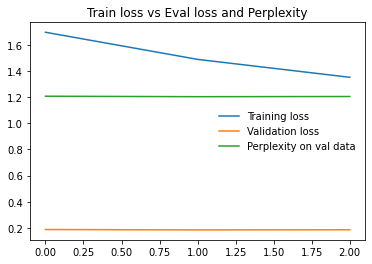

In [33]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [34]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in enumerate(dataset_loader):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=1,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.decoder.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results


#### Loading Saved Model

In [ ]:
pretrained = False

if pretrained:    

    model = .... # first initialize the model and optimizer

    #optimizer = ... # optimizer then,
    infile = open(pcle,'rb')
    optimizer = pickle.load(infile)
    infile.close()

    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [61]:
!ls /root/Projects


Final_Project.ipynb	     Wheat_rust_classification.ipynb
README.md		     model.pt
T5_ftransfer_learning.ipynb  valid_processed.pkl
Untitled.ipynb		     wandb


In [22]:
model.load_state_dict(torch.load('/root/Projectsmodel0.pt'))
model = model.to(device)

In [23]:
#model = torch.load('/root/Projects/model.pt')

In [74]:
ivind = valind[5000:6000]

X_trial = X_valid.iloc[ivind]

Xtest_trial = X_trial.reset_index(drop=True)

argsval = {'max_article_tokens': 512,
                'max_summary_tokens': 150
             }
    
    
val_loader  = get_dataloader(Xtest_trial, 6,valid='valid', **argsval)

In [36]:
%time results = generator(model, val_loader)

CPU times: user 13min 36s, sys: 17.9 s, total: 13min 54s
Wall time: 11min 36s


In [75]:
 input_ids, source_mask, summary_ids, summary_mask = next(iter(val_loader))

#### Visualizing examples

**Example 1**

In [37]:
Xtest_trial.iloc[0,:]['text']

'It s an election year, so of course Bristol Palin is returning to Dancing With the Stars for the show s first all star cast.\n\nWill Palin s presence revive the controversy and high ratings of her original competition in Season 11? During fall 2010, with her politico mom campaigning not only for her dancing daughter but for tea party candidates, Bristol finished third. The tea party did pretty well, too. \n\nBut it was Bristol, known for being an unwed teen mom and not necessarily her dancing, who brought the buzz. A Wisconsin man shot his television in anger over her success. No chill pills handy? There were accusations never proven of voting conspiracies.\n\nAnd Twitter took off when mom also known as 2008 vice presidential nominee and former Alaska governor Sarah Palin showed up in the front row of the dance floor.\n\nFor the show s 15th season, Palin will compete with other past stars. And the competition will be considerably stiffer.\n\nThe cast features a half dozen past winners

In [38]:
print("Actual summary:")
results['golden_summary'][0]

Actual summary:


'Will her presence boost the ABC reality dancing show during a controversial political season?'

In [39]:
print('Generated summary:')
results['generated_summary'][0]

Generated summary:


'Twitter took off when mom Sarah Palin showed up in the front row of dance floor. And competition will be considerably stiffer for 13th contestant one will online voters in August, a show featuring military exercises and missions reported E! reported that Mother Sarah had Alaska Alaska mother Mom E! reported'

**Example 2**

In [40]:
Xtest_trial.iloc[1,:]['text']

'You don t diss the Kiss Cam.\n\nAn unlucky boyfriend found that out the hard way when he refused to pucker up for his girl and instead stayed on his phone at a major league baseball game.\n\nRELATED SEE IT POSSIBLY THE WORST FIRST PITCH EVER\n\nShe, in turn, poured her drink all over him and then stormed off in front of thousands of jeering fans.\n\nKiss Cam footage from Fresno Grizzlies May 3 game begins with couples smooching in front of the crowds as the lens falls on them.\n\nRELATED ANGRY BIRDS ADDICT PROPOSES VIA CUSTOM GAME LEVEL\n\nBut when it is aimed at the as yet unnamed couple, the man opts to continue his call and brushes her away.\n\nThe camera pans back to the pair twice before the woman has enough and throws her beverage all over him.\n\nRELATED SEE IT MAN BUSTS A MOVE ON A MOVING TREADMILL\n\nShe then walks off, to his disbelief, into the arms of the Grizzlies bear mascot.\n\nVideo of the hilarious incident has been seen more than 500,000 times, but some have speculat

In [41]:
print("Actual summary:")
results['golden_summary'][1]

Actual summary:


'You don t diss the Kiss Cam. An unlucky boyfriend found that out the hard way when he refused to pucker up for his girl and instead stayed on his phone at a major league baseball game. She, in turn, poured her drink all over him and then stormed off in front of thousands of jeering fans.'

In [42]:
print('Generated summary:')
results['generated_summary'][1]

Generated summary:


'You don t diss the Kiss Cam. An unlucky boyfriend found that out, to his disbelief, into kissed bear mascot'

**Example 3**

In [43]:
Xtest_trial.iloc[3,:]['text']

'HAVANA AP Two well known Cuban dissidents were released from prison Saturday, despite the fact both men said they wanted to remain in jail until other opposition leaders were freed and other demands were met.\n\nThe release of Hector Maseda and Angel Moya means that just seven of the original 75 opposition figures arrested in a 2003 crackdown remain in Cuban jails but neither was happy about it.\n\nThe decision to release Moya was announced more than a week ago, but he had refused to leave jail saying he wanted ailing dissidents to go free first. On Friday, the Roman Catholic Church announced that the government wanted to release Maseda, but he too turned them down, saying he wanted authorities to exonerate or pardon him, not simply grant him parole.\n\nIn the end, jail officials simply tossed the men out, saying they could no longer stay behind bars, even if they wanted to.\n\n I have left prison against my will, Maseda told journalists after arriving at his home in the capital, Hava

In [44]:
print("Actual summary:")
results['golden_summary'][3]

Actual summary:


'Two well known Cuban dissidents were released from prison Saturday, despite the fact both men said they wanted to remain in jail until other opposition leaders were freed and other demands were met.'

In [45]:
print('Generated summary:')
results['generated_summary'][3]

Generated summary:


'He Cuba s exile in Spain and Down with the worm! The worm!! Ma small group of protesters screamed at him from his street, shouting slogan Fidel! Fidela L! Fidell! Fidele to my will.'

**Example 4**

In [46]:
Xtest_trial.iloc[4,:]['text']

'Kayla Harrison enters an ordinary door on a gray street on the outskirts of the Garment District. She walks past the doorman, who doesn t look up from his newspaper, and goes down the stairs to arrive at Renzo Gracie s jiu jitsu academy.\n\nThere is no entourage, no handlers, no TMZ, just her and a bunch of sweaty fighters who pay her no mind.\n\nYou wouldn t know she is the most successful American judo Olympian in history. That she is far more accomplished in her sport than Ronda Rousey ever was.\n\nAnd she would prefer if the inevitable comparisons to Rousey stop right there, even as she seems set to follow in Rousey s path.\n\n In terms of what I would learn from her Harrison told The Post, her voice trailing off a bit as she thought about her former teammate. I don t know. It s such a different world and her rise to fame was just like almost overnight, and I think that s a lot of pressure to deal with.\n\n For me, it s about staying true to my roots. I don t want to have any yes 

In [47]:
print("Actual summary:")
results['golden_summary'][4]

Actual summary:


'Kayla Harrison enters an ordinary door on a gray street on the outskirts of the Garment District. She walks past the doorman, who doesn t look up from his newspaper, and goes down the stairs to arr'

In [48]:
print('Generated summary:')
results['generated_summary'][4]

Generated summary:


'Kayla Harrison says she is going to achieve her goal while staying trueto my roots. I don t want have comparisons that Ronda Rousey are unlikely disipate'

**Example 5**

In [49]:
Xtest_trial.iloc[5,:]['text']

'Eric McElvenny was a U.S. Marines captain in Afghanistan when he stepped on an improvised explosive device in late 2011. After surgeons amputated most of his lower right leg, McElvenny received an email from his commanding officer who wanted to know when he d be running his first marathon. McElvenny decided to take that motivational suggestion even further by competing in triathlons, including several at the Ironman level. Those consist of a 2.4 mile swim, a 112 mile bike ride and a marathon 26.2 miles .\n\nFor his latest challenge, McElvenny is preparing to tackle the 106 West Triathlon at Lake Dillon in Colorado on September 10. The distances are 1.2 miles of swimming, 56 miles of biking and 13.1 miles of running. But the real killer is the elevation, which starts at nearly 9,100 feet and maxes out at 10,291 feet.\n\nCrazy? Yes. But as McElvenny says, That sounds like a reason to go do it. \n\nHere is more about McElvenny, 33, a U.S. Naval Academy graduate who now lives in the San D

In [50]:
print("Actual summary:")
results['golden_summary'][5]

Actual summary:


'Marine Capt. Eric McElvenny lost most of his lower right leg after stepping on an IED in Afghanistan. Now he is competing in triathlons.'

In [51]:
print('Generated summary:')
results['generated_summary'][5]

Generated summary:


'U.S Naval Eric McElny is preparing to tackle his Ironman level triathlon in Afghanistan and works as an inspirational speaker'

**Example 6**

In [52]:
Xtest_trial.iloc[6,:]['text']

'In their critics eyes, producers of sugar sweetened drinks are acting a lot like the tobacco industry of old marketing heavily to children, claiming their products are healthy or at worst benign, and lobbying to prevent change. The industry says there are critical differences in moderate quantities soda isn t harmful, nor is it addictive.\n\nThe problem is that at roughly 50 gallons per person per year, our consumption of soda, not to mention other sugar sweetened beverages, is far from moderate, and appears to be an important factor in the rise in childhood obesity. This increase is at least partly responsible for a rise in what can no longer be called adult onset diabetes because more and more children are now developing it.\n\nAttention is being paid Last week, the Obama administration announced a plan to ban candy and sweetened beverages from schools. A campaign against childhood obesity will be led by the first lady, Michelle Obama. And a growing number of public health advocates

In [53]:
print("Actual summary:")
results['golden_summary'][6]

Actual summary:


'Can a soda tax and warning labels help dam the river of sugared drinks Americans pour into ever fatter bodies each year?'

In [54]:
print('Generated summary:')
results['generated_summary'][6]

Generated summary:


'With all a tax on sugared beverages, would lead to drop energy leading. Even eliminating one food that has spoken the most seriously about building an healthier portfolio, can t be done by different'

**Example 7**

In [55]:
Xtest_trial.iloc[7,:]['text']

'What does your personal budget look like? If you ve never put cursor to spreadsheet to figure that out, the flagging economy may soon force your hand. If you have, and are dismayed by the data, you might want to think hard about where those precious dollars are going and why.\n\nFor some valuable perspective and perhaps belt tightening inspiration , take a look at global consumer spending patterns. Data from the World Bank s most recent and hugely comprehensive International Comparison Program study breaks global individual consumption into 11 buckets from food and clothing to health care and recreation.\n\nForbes.com took a snapshot of overall allocations for 18 countries, measured as percentages of total individual consumption rounded to the nearest percent . While the figures capture patterns as of 2005, recent inflation in energy and food prices no doubt has shifted these results a bit.\n\nThe most striking and downright shocking data are the disparities in the relative chunks of 

In [56]:
print("Actual summary:")
results['golden_summary'][7]

Actual summary:


'Herewith, a global household spending breakdown. How do you stack up?'

In [57]:
print('Generated summary:')
results['generated_summary'][7]

Generated summary:


'What does your budget spend a whopping 18 to medical care and the like. Americans, long strapped by an sadly inefficient health system, allt 24 of their incomes, most top among'

**Example 8**

In [58]:
Xtest_trial.iloc[8,:]['text']

'Perhaps it s because, while poor people are not lazy, they are not stupid either. If you pay people more not to work than they can earn at a job, many won t work.\n\nA new study by the Cato Institute found that in many states, it does indeed pay better to be on welfare than it does to work.\n\nMost reports on welfare focus on only a single program, the cash benefit program Temporary Assistance for Needy Families. This focus leaves the misimpression that welfare benefits are quite low, providing a bare, subsistence level income. In reality, the federal government funds 126 separate programs for low income people, 72 of which provide either cash or in kind benefits to individuals.\n\nBecause there are so many categories of welfare recipients and so many different types of benefits, it is extremely difficult to determine how many people get what combination of benefits. For the purposes of this study, we assumed a hypothetical family consisting of a mother with two children, ages 1 and 4

In [59]:
print("Actual summary:")
results['golden_summary'][8]

Actual summary:


'Contrary to stereotypes, there is no evidence that people on welfare are lazy. Indeed, surveys of welfare recipients consistently show their desire for a job. But there is also evidence that many are reluctant to accept available employment opportunities. Despite work requirements included in the 1996 welfare reform, the U.S. Department of Health and Human Services says less than 42 of adult welfare recipients participate in work activities nationwide. Why the contradiction?'

In [60]:
print('Generated summary:')
results['generated_summary'][8]

Generated summary:


'A state Approximately profile family, they would not be eligible for W but would receive other benefits such as foodsubsidized school lunchs and breakfast meals. If the children were older, their wouldn no, them could non, they didnt on that program'

**Example 9**

In [61]:
Xtest_trial.iloc[9,:]['text']

'With precious metals prices tumbling over the past week, gold has held onto its value a lot better than silver. For some people, gold is the ultimate safe haven commodity. For most people owning the metal means buying gold bars or an ETF, but some people choose to splash out on something a little more fashionable and fun, like a piece of decadent luxury that won t go out of style even if gold prices were to fall. So here s a look at the 10 most outrageous items some people have found to stake their gold claims.By Michael KearnsPosted April 28, 2011'

In [62]:
print("Actual summary:")
results['golden_summary'][9]

Actual summary:


'For some people, gold is the ultimate safe haven commodity. Here s a look at the 10 most outrageous items some people have found to stake their gold claims.'

In [63]:
print('Generated summary:')
results['generated_summary'][9]

Generated summary:


'For some people, gold is the ultimate safe haven commodity. But for a few or an ETF and other precious assets are still in fashion'

**Example 10**

In [64]:
Xtest_trial.iloc[15,:]['text']

'BUENOS AIRES, May 21 The first official news here today of the British landings on the Falkland Islands was communique No. 68 from the Argentine Joint Chiefs of Staff, which was broadcast by radio stations at about 11 A.M.\n\n The Joint Chiefs of Staff communicate that on the date of 21 May 1982, at 8 45, three ships were detected in the bay of Puerto San Carlos, it said, referring to an East Falkland inlet, and one ship to the north of the mouth of the strait of San Carlos, and that at 8 50 a disembarkation began which is being resisted by our own forces. \n\nLike most of the 67 previous communiques that have been issued since Britain recaptured the South Atlantic island of South Georgia on April 25, No. 68 was sparse in language. But it conveyed to the information hungry foreign press corps in Buenos Aires that the junta was acknowledging that British troops were on the Falklands. Report Initially Discounted\n\nThree hours earlier in London, at his regular noon briefing, Ian McDonal

In [65]:
print("Actual summary:")
results['golden_summary'][15]

Actual summary:


'The first official news here today of the British landings on the Falkland Islands was communique No. 68 from the Argentine Joint Chiefs of Staff, which was broadcast by radio stations at about 11 A.M. The Joint Chiefs of Staff communicate that on the date of 21 May 1982, at 8 45, three ships were detected in the bay of Puerto San Carlos, it said, referring to an East Falkland inlet, and one ship to the north of the mouth of the strait of San Carlos, and that at 8 50 a disembarkation began which is being resisted by our own forces. Like most of the 67 previous communiques that have been'

In [66]:
print('Generated summary:')
results['generated_summary'][15]

Generated summary:


'The sequence is ilrative of the way news breaks, or does not break to broken, in Argentina. To its morning roundup on an account that It quoted onenamed spokesman atcoffing at report British troops and Reportede Three hours earlier London briefn Ian McDonald Britain raiders party put ashore there Falklands during the night. In the gap between Mr said manch his tersette announcement in London withe Anne from UK British defence Ministry s Spokesman for Italian German press media had put  A number of raiding, Ian McDonald te communtone Sunday it choseto call the Argentini name un Chile called the juntagate at the reportse story here Ian McDonald w e English esc Ian McDonald o regular noon briefing, Ian McDonald ish parties have put  Frenchmen, Ian McDonald and threee announced that  many military raider brera E King, Ian McDonald y    rest British Irish Dutch Army a teren statement in Falklander English Foreign Telam newspaper calling B C. In two Peter, the British Defense Minster entree

### Performance

In [67]:
!pip3 install rouge
from rouge import Rouge

In [68]:
!pip3 install rouge-score tqdm
from rouge_score import rouge_scorer, scoring

In [69]:
from typing import Dict

def get_score(summaries) -> Dict:  
    
    src_labels = summaries['golden_summary']
    gen_summary = summaries['generated_summary']
    
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()
    
    for src, gent in zip(src_labels, gen_summary):
        scores = scorer.score(gent, src)
        aggregator.add_scores(scores)
        
    results = aggregator.aggregate()
    return {key: val.mid.fmeasure for key, val in results.items()}

In [70]:
get_score(results)

{'rouge1': 0.2030570887244602,
 'rouge2': 0.06251118970800382,
 'rougeL': 0.15324285588553116}

In [ ]:
{'rouge1': 0.3251555298232545,
 'rouge2': 0.17724507880716306,
 'rougeL': 0.2734545655096767}

In [71]:
rouge = Rouge()

score = rouge.get_scores(results['generated_summary'], results['golden_summary'], avg=True)
{key: val['f'] for key, val in score.items()}

{'rouge-1': 0.17495709704403886,
 'rouge-2': 0.05524631427401131,
 'rouge-l': 0.15704499693845222}

In [ ]:
{'rouge-1': 0.2934569607894014,
 'rouge-2': 0.16207342615668757,
 'rouge-l': 0.2762959592687011}

##### Freezing layers

In [ ]:
model.decoder.block[11].requires_grad=True
model.decoder.block[4].requires_grad=True

for param model.parameters():
    param.requires_grad = False

In [ ]:
class T5Model(nn.Module):

  def __init__(self, t5, )

In [ ]:
class DictionaryDataset:
  def __init__(self, dataset=None):
    self.w2index = defaultdict(int)
    self.index2w = defaultdict(lambda: 'SOS')
    self.symbols = ['SOS','EOS','PAD']
    self.wcount = 3

    for i, s in enumerate(self.symbols):
      self.index2w[i] = s
    for i, s in enumerate(self.symbols):
      self.w2index[s] = i
      
    if dataset:
      for i, line in tqdm(enumerate(dataset)):
        self.word2index(line)

  def word2index(self, sentence):
    words = sentence.split()
    for word in words:
      if word not in self.w2index.keys():
        self.w2index[word] = self.wcount
        self.index2w[self.wcount] = word
        self.wcount +=1
    
  def encode_sequence(self, dataset):
    for i, line in tqdm(enumerate(dataset)):
      self.word2index(line)

  def decode_idx(self, idx):
    dec_words = []
    for i in idx:
      dec_words.append(self.index2w[i])
    return dec_words

![LSTM](https://drive.google.com/open?id=19pYBGaKGx2wTHjDC3QLMkpr5HDqTPbb6)

![Seq2SeqWithAttention](https://drive.google.com/open?id=1QDLNN0XQ0TfeA-nyAGBhG3YgwAX0bPQU)

You should use the same number of layers, for encoder and decoder
shape for inputs is (batch size, sequence length), (batch size, 1) respectively.


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size, embed_size, num_hidden, batch_size, num_layers=3, dropout = 0.1):
    super(Encoder, self).__init__()
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.input_size = input_size
    self.batch_size = batch_size

    self.embed = nn.Embedding(input_size, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=num_hidden,num_layers = num_layers, dropout=(0 if num_layers ==2 else dropout))

  def init_hidden(self):
     # The axes semantics are (num_layers, minibatch_size, hidden_dim)
    return (torch.zeros(self.num_layers, self.batch_size, self.num_hidden), torch.zeros(self.num_layers, self.batch_size, self.num_hidden))
  def forward(self, input, hidden):
    # input (batch size, sequence length)
    embedding = self.embed(input)
    #print(embedding.shape)
    embed_out = embedding.transpose(0,1)
    print(embed_out.shape)
    lstm_out, hidden = self.lstm(embed_out, hidden)

    # The shape of lstm_out is (seq_len, batch_size, num_hiddens).
    # state contains the hidden state and the memory cell
    # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
    #lstout is (seq_length, batch_size, num_hiddens)
    return lstm_out, hidden

In [ ]:
encoder = Encoder(input_size =10, embed_size=8, num_hidden=16, batch_size=4)
X = torch.zeros((4, 7),dtype=torch.long)
hidden = encoder.init_hidden()
output, hidden = encoder(X, hidden)

torch.Size([7, 4, 8])


In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])

In [ ]:
output.shape

torch.Size([7, 4, 16])

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size, method='dot'):
    super(Attention, self).__init__()
    self.method = method
    self.hidden_size = hidden_size
  def dot_score(self, hidden, encoder_output):
    return torch.sum(hidden * encoder_output, dim=2)

  def forward(self, hidden, encoder_output):
    att_prod = self.dot_score(hidden, encoder_output)
    attn_weights = att_prod.t()
    return F.softmax(attn_weights, dim=1).unsqueeze(1)



In [ ]:
class DecoderWithAtt(nn.Module):
  def __init__(self, embed_size_in, num_hidden, output_size, att_method=None, num_layers = 3):
    super(DecoderWithAtt, self).__init__()
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.output_size = output_size
    self.att_method = att_method

    self.emb = nn.Embedding(embed_size_in, num_hidden)
    self.lstm = nn.LSTM(input_size=num_hidden, hidden_size=num_hidden, num_layers = num_layers)
    self.con_ln = nn.Linear(num_hidden * 2, num_hidden)
    self.drop = nn.Dropout(p=0.2)
    self.fc  = nn.Linear(self.num_hidden, self.output_size)
    self.attention = Attention(att_method, num_hidden)

  def forward(self, prev_hidden, target_input, enconder_outputs):
    embed_out = self.emb(target_input).transpose(0,1)
    embed_out = self.drop(embed_out)
    print('embed out >>>', embed_out.shape)
    output, hidden = self.lstm(embed_out, prev_hidden) # shape (1, batch_size, hidden_size), 1 for one time step word 
    print('lstm out >>>', output.shape)
    print('hidden out >>>', hidden[0].shape)

    attent_weights = self.attention(output, enconder_outputs) # (att out shape: batch_size, 1, max_length), enc in shape: (max_length, batch_size, hidden_size)
    print('attent_weights out >>>', attent_weights.shape)
    print('enconder_outputs >>>', enconder_outputs.shape)

    context = torch.bmm(attent_weights, enconder_outputs.transpose(0,1))
    print('context out >>>', context.shape)
    cont_dec_out = torch.cat((context, output.transpose(0,1)), 1)
    print('to linear out >>>', cont_dec_out.shape)
    cont_dec_out = cont_dec_out.view(cont_dec_out.shape[0], -1)
    concat_out = self.con_ln(cont_dec_out)
    concat_out = torch.tanh(concat_out)

    out = self.fc(concat_out)
    out = F.softmax(out, dim=1)

    return out, hidden

In [ ]:
decoder = DecoderWithAtt(10,16,2)

In [ ]:
x = torch.zeros((4, 1),dtype=torch.long)
out, hidden = decoder(hidden, x, output)

embed out >>> torch.Size([1, 4, 16])
lstm out >>> torch.Size([1, 4, 16])
hidden out >>> torch.Size([3, 4, 16])
attent_weights out >>> torch.Size([4, 1, 7])
enconder_outputs >>> torch.Size([7, 4, 16])
context out >>> torch.Size([4, 1, 16])
to linear out >>> torch.Size([4, 2, 16])


In [ ]:
out.shape

torch.Size([4, 2])

In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])